### Simple example
This code shows as simple way to:
- Read in a .nc file using xarray & calculate a climatology
- convert to uxarray dataset
- plot regional climo means and maps

In [1]:
#import cf_units as cf
#import esmlab
#from ctsm_py import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date

# some resources for plotting
import matplotlib
import matplotlib.pyplot as plt

import xarray as xr
import uxarray as ux  #need npl 2024a
import geoviews.feature as gf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os,sys
from glob import glob
from os.path import join
#import hvplot.xarray
#import holoviews as hv
#hv.extension('bokeh')

print('ux version '+ux.__version__)
%matplotlib inline

ux version 2025.3.0


In [2]:
## User defined options
unstructured = True
path = '/glade/derecho/scratch/hannay/archive/'
suff = '/lnd/hist/'
cases = ['b.e30_alpha06e.B1850C_LTso.ne30_t232_wgx3.156',
         'b.e30_alpha06e.B1850C_LTso.ne30_t232_wgx3.155',
         'b.e30_alpha06b.B1850C_LTso.ne30_t232_wgx3.147']
short_cases = [cases[0][-3:], cases[1][-3:], cases[2][-3:]]
vars  = ['TREFMXAV', 'RAIN', 'SNOW',
         'QRUNOFF_TO_COUPLER', 'QRUNOFF_ICE_TO_COUPLER']
nyears = 1
iyears = -12 * nyears

fin0, fin1, fin2 = [],[],[]
fin0.extend(sorted(glob(join(path+cases[0]+suff+'*.nc'))))
fin1.extend(sorted(glob(join(path+cases[1]+suff+'*.nc'))))
fin2.extend(sorted(glob(join(path+cases[2]+suff+'*.nc'))))
fin0[-1]

'/glade/derecho/scratch/hannay/archive/b.e30_alpha06e.B1850C_LTso.ne30_t232_wgx3.156/lnd/hist/b.e30_alpha06e.B1850C_LTso.ne30_t232_wgx3.156.clm2.h0.0044-12.nc'

In [3]:
def preprocess(ds):
    return ds[vars]

In [4]:
# read in datasets and create climatology
mesh = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'

# xarray for regular grids
ds0 = xr.open_mfdataset(fin0[iyears:], decode_times=True, preprocess = preprocess)\
        .groupby("time.month").mean('time')
ds1 = xr.open_mfdataset(fin1[iyears:], decode_times=True, preprocess = preprocess)\
        .groupby("time.month").mean('time')
ds2 = xr.open_mfdataset(fin2[iyears:], decode_times=True, preprocess = preprocess)\
        .groupby("time.month").mean('time')
if unstructured == True:
    ux_grid = ux.open_mfdataset(mesh, fin0[-2:], preprocess = preprocess)

print(' -- Read in datasets -- ')

 -- Read in datasets -- 


In [8]:
# convert to ux datasets
ds0 = ux.UxDataset.from_xarray(ds0, uxgrid=ux_grid.uxgrid) 
ds1 = ux.UxDataset.from_xarray(ds1, uxgrid=ux_grid.uxgrid) 
ds2 = ux.UxDataset.from_xarray(ds2, uxgrid=ux_grid.uxgrid) 

# concat datasets
ds = ux.concat([ds0, ds1, ds2],'case').assign_coords(case=short_cases)
ds['PPT'] = ds.RAIN + ds.SNOW
vars  = ['TREFMXAV', 'PPT',
         'QRUNOFF_TO_COUPLER', 'QRUNOFF_ICE_TO_COUPLER']
ds

<xarray.UxDataset> Size: 42MB
Dimensions:                 (case: 3, month: 12, n_face: 48600)
Coordinates:
  * month                   (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * case                    (case) <U3 36B '156' '155' '147'
Dimensions without coordinates: n_face
Data variables:
    TREFMXAV                (case, month, n_face) float32 7MB dask.array<chunksize=(1, 1, 48600), meta=np.ndarray>
    RAIN                    (case, month, n_face) float32 7MB dask.array<chunksize=(1, 1, 48600), meta=np.ndarray>
    SNOW                    (case, month, n_face) float32 7MB dask.array<chunksize=(1, 1, 48600), meta=np.ndarray>
    QRUNOFF_TO_COUPLER      (case, month, n_face) float32 7MB dask.array<chunksize=(1, 1, 48600), meta=np.ndarray>
    QRUNOFF_ICE_TO_COUPLER  (case, month, n_face) float32 7MB dask.array<chunksize=(1, 1, 48600), meta=np.ndarray>
    PPT                     (case, month, n_face) float32 7MB dask.array<chunksize=(1, 1, 48600), meta=np.ndarray>

## Subset data for regions
- this is really slow!  Maybe dask would help?
- uxarray subset function only works on data arrays, not datasets 

plotted TREFMXAV
plotted PPT
plotted QRUNOFF_TO_COUPLER
plotted QRUNOFF_ICE_TO_COUPLER


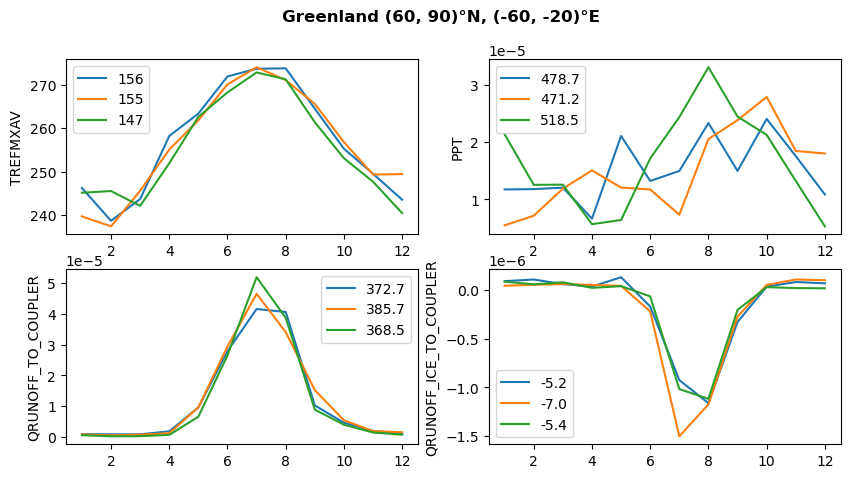

In [9]:
# Create a bounding box around region
region, lat_bounds, lon_bounds = 'Greenland', (60, 90), (-60, -20)
#region, lat_bounds, lon_bounds = 'SW Greenland', (58, 70), (-57, -45)
#region, lat_bounds, lon_bounds = 'Antarctica', (-90, -60), (-180, 180)

# climatology plots
plt.figure(figsize=[10,5])
x = range(1,13)
for i in range(len(vars)):
    plt.subplot(2,2,(i+1))
    for c in range(len(short_cases)):
        y = ds[vars[i]].isel(case=c).subset.bounding_box(lon_bounds, lat_bounds).mean('n_face').values
        if i == 0:
            plt.plot(x,y, label=short_cases[c])
        else: # add integral under curve to legend
            plt.plot(x,y, label=str(np.round((y.mean()*3600*24*365),1)))
            
    plt.ylabel(vars[i],  fontsize='medium')
    plt.legend() 
    print('plotted ' + vars[i])

plt.suptitle(region+" "+str(lat_bounds)+"°N, "+str(lon_bounds)+"°E", 
             fontsize='large', fontweight='bold') ;

plotted TREFMXAV
plotted PPT
plotted QRUNOFF_TO_COUPLER
plotted QRUNOFF_ICE_TO_COUPLER


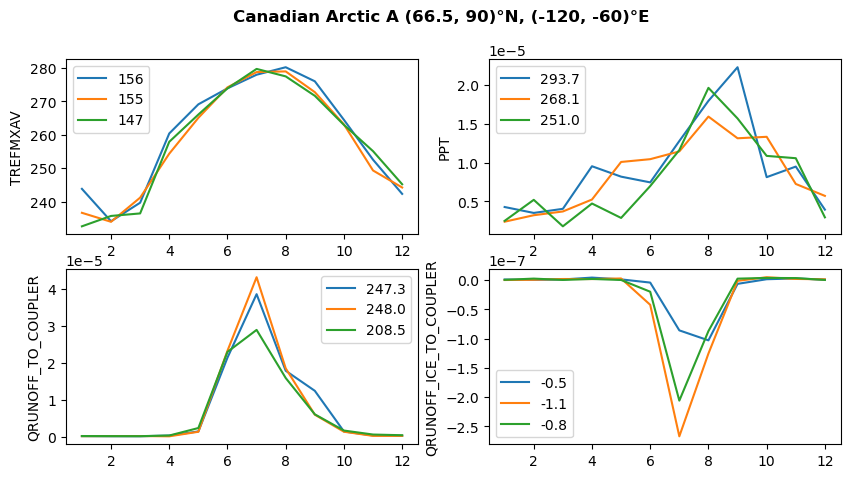

In [10]:
# Additional regional climo plots
region, lat_bounds, lon_bounds = 'SW Greenland', (58, 70), (-57, -45)
region, lat_bounds, lon_bounds = 'Canadian Arctic B', (58, 70), (-80, -60)
region, lat_bounds, lon_bounds = 'Canadian Arctic A', (66.5, 90), (-120, -60)

# climatology plots
plt.figure(figsize=[10,5])
x = range(1,13)
for i in range(len(vars)):
    plt.subplot(2,2,(i+1))
    for c in range(len(short_cases)):
        y = ds[vars[i]].isel(case=c).subset.bounding_box(lon_bounds, lat_bounds).mean('n_face').values
        if i == 0:
            plt.plot(x,y, label=short_cases[c])
        else: # add integral under curve to legend
            plt.plot(x,y, label=str(np.round((y.mean()*3600*24*365),1)))
            
    plt.ylabel(vars[i],  fontsize='medium')
    plt.legend() 
    print('plotted ' + vars[i])

plt.suptitle(region+" "+str(lat_bounds)+"°N, "+str(lon_bounds)+"°E", 
             fontsize='large', fontweight='bold') ;

:Overlay
   .Image.I     :Image   [x,y]   (x_y TREFMXAV)
   .Coastline.I :Feature   [Longitude,Latitude]
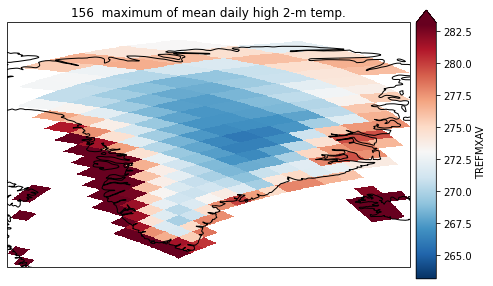

In [24]:
# Slightly larger box than wha's being avereged over above
region, lat_bounds, lon_bounds = 'Greenland', (58, 87), (-65, -18)
projection=ccrs.PlateCarree()

plot_opts = {"width": 600, "height": 400}
features = gf.coastline(projection=projection, scale="50m") 

clim = (ds[vars[0]].isel(case=0).values.min(), ds[vars[0]].isel(case=0).values.max())

ux_region = ds[vars[0]].isel(case=0).subset.bounding_box(lon_bounds, lat_bounds).max('month')
plot_bbox = (
    ux_region.plot(
        rasterize=True,
        periodic_elements="exclude",
        clim=(263.15,283.15),
        cmap="RdBu_r",
        title = short_cases[0] + "  maximum of mean daily high 2-m temp.",
        **plot_opts,
    )
    * features
)
plot_bbox

:Overlay
   .Image.I     :Image   [x,y]   (x_y TREFMXAV)
   .Coastline.I :Feature   [Longitude,Latitude]
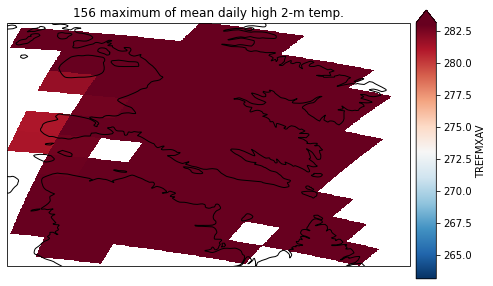

In [23]:
region, lat_bounds, lon_bounds = 'Canadian Arctic B', (58, 70), (-80, -60)
projection=ccrs.PlateCarree()

#region, lat_bounds, lon_bounds = 'Antarctica', (-90, -60), (-180, 180)
#projection=ccrs.Orthographic(central_latitude=90)

plot_opts = {"width": 600, "height": 400}
features = gf.coastline(projection=projection, scale="50m") 

clim = (ds[vars[0]].isel(case=0).values.min(), ds[vars[0]].isel(case=0).values.max())

ux_region = ds[vars[0]].isel(case=0).subset.bounding_box(lon_bounds, lat_bounds).max('month')
plot_bbox = (
    ux_region.plot(
        rasterize=True,
        periodic_elements="exclude",
        clim=(263.15,283.15),
        cmap="RdBu_r",
        title = short_cases[0] + " maximum of mean daily high 2-m temp.",
        **plot_opts,
    )
    * features
)
plot_bbox

:Overlay
   .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude TREFMXAV)
   .Coastline.I :Feature   [Longitude,Latitude]
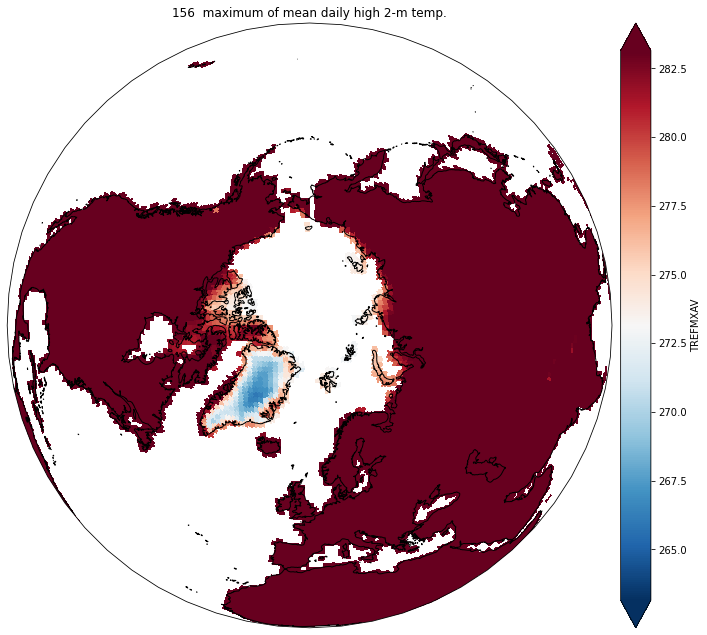

In [27]:
plot_opts = {"width": 900, "height": 400}
projection = ccrs.Orthographic(central_latitude=90,)
features = gf.coastline(projection=projection, scale="50m") 

ds[vars[0]].isel(case=0).max('month').plot.polygons(
    rasterize=True,
    projection=projection,
    backend="matplotlib",
    #pixel_ratio=8.0,
    title = short_cases[0] + "  maximum of mean daily high 2-m temp.",
    cmap="RdBu_r",
    clim=(263.15,283.15),
    **plot_opts,
) * features